<a href="https://colab.research.google.com/github/madhulikag/BanaNET/blob/main/Bananutrient_multi_binary_classes_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Conv2D, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image


import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Image directory, change to yours as needed
data_dir = '/content/drive/MyDrive/Banana_leaf'

image_size = (224, 224)
batch_size = 32


In [4]:
# Data Processing for unorganized directory
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 2657 images belonging to 4 classes.
Found 664 images belonging to 4 classes.


In [5]:
# Data Processing for organized directory
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Banana_leaf_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Banana_leaf_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

Found 2657 images belonging to 4 classes.
Found 664 images belonging to 4 classes.


In [6]:
# input shape: image size and RGB
base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model weights for now
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)  # pass inputs through base model
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by 50%
    patience=2,        # Wait 2 epochs before reducing
    min_lr=1e-6,       # Don't go below this LR
    verbose=1
)



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3550 - loss: 1.4965

84/84 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.3558 - loss: 1.4947 - val_accuracy: 0.6160 - val_loss: 0.9481 - learning_rate: 1.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5592 - loss: 1.0017

84/84 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5594 - loss: 1.0014 - val_accuracy: 0.6657 - val_loss: 0.8314 - learning_rate: 1.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6488 - loss: 0.8582

84/84 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6488 - loss: 0.8580 - val_accuracy: 0.6837 - val_loss: 0.7690 - learning_rate: 1.0000e-04
Epoch 4/30
60/84 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6778 - loss: 0.7966

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict probabilities
y_pred_probs = model.predict(val_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the generator
y_true = val_generator.classes

In [ ]:
from sklearn.metrics import classification_report
# Generate classification report with class names
class_labels = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# Generate Confusion matrix with class names
class_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, base_model):
    # Create a model that maps the input image to the activations of the last conv layer
    # and the final output predictions
    grad_model = tf.keras.models.Model(
        [model.input],
        [base_model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]

    # This is the gradient of the output neuron (top predicted class) with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, conv_outputs)

    # Global average pooling the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important it is" with regard to the top class
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to 0-1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
model.summary()

In [50]:
base_model = model.layers[0]
for layer in base_model.layers[::-1]:  # reverse order
    if 'conv' in layer.name:
        print(layer.name)
        break  # first one found in reverse is the last conv layer

top_conv


In [45]:
last_conv_name = "top_conv"

In [46]:
from tensorflow.keras.preprocessing import image
# Path to the test image (adjust as needed)
img_path = '/content/drive/MyDrive/Banana_leaf/potassium/k3.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

In [47]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_name, base_model)

AttributeError: The layer sequential has never been called and thus has no defined input.

In [21]:
# Begin work on EfficientNetB3
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

In [22]:
# Data Processing for unorganized directory
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 2657 images belonging to 4 classes.
Found 664 images belonging to 4 classes.


In [23]:
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3)  # EfficientNetB3 expects 300x300
)
base_model.trainable = False  # Freeze initially

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
model = Sequential([
    Input(shape=(300, 300, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # change to match your number of classes
])
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "efficientnetb3" is incompatible with the layer: expected shape=(None, 300, 300, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

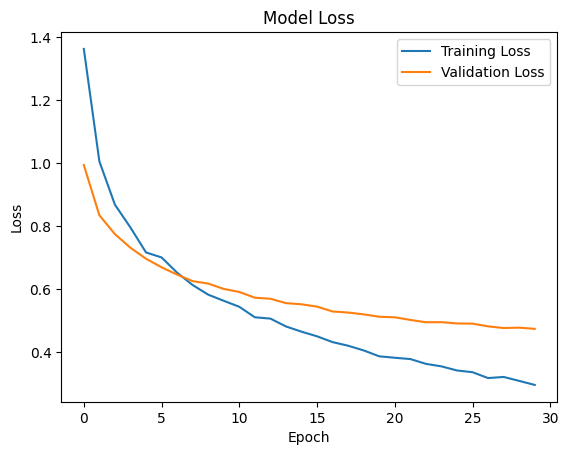

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Predict probabilities
y_pred_probs = model.predict(val_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the generator
y_true = val_generator.classes

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "efficientnetb3" is incompatible with the layer: expected shape=(None, 300, 300, 3), found shape=(32, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None

In [28]:
# Generate classification report with class names
class_labels = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

     healthy       0.80      0.76      0.78       190
   magnesium       0.83      0.90      0.86       160
   potassium       0.89      0.86      0.87       168
     sulphur       0.67      0.69      0.68       146

    accuracy                           0.80       664
   macro avg       0.80      0.80      0.80       664
weighted avg       0.80      0.80      0.80       664



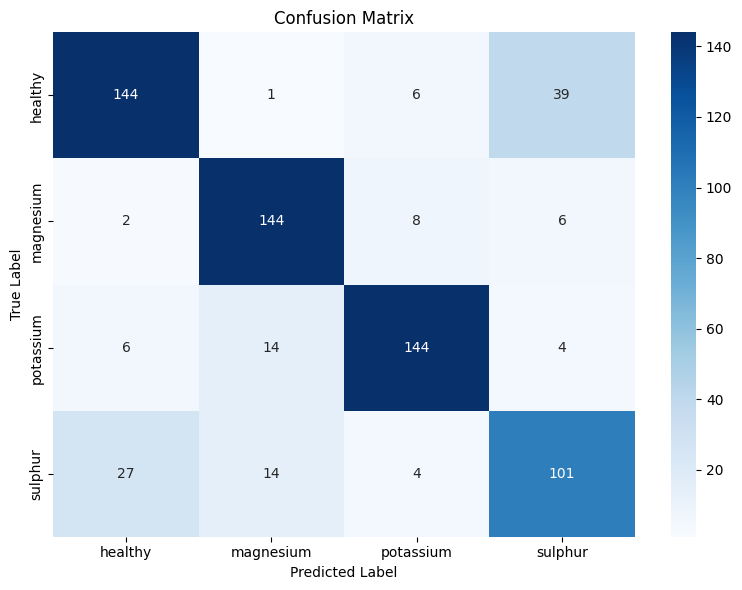

In [29]:
cm = confusion_matrix(y_true, y_pred)

# Generate Confusion matrix with class names
class_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()